In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
class SORN:
    '''
    Implements the SORN parameters and activation, without training
    Importantly, preserves plasticity mechanisms
    
    Cells below visualize the network in various ways using matplotlib
    
    '''
    # number of neurons
    N_input = 10
    N_ex = 80
    N_in = 20

    # noise
    noise_mean = 0
    noise_sigma = 0.5

    # connectivity
    p_IE = 1

    # maximum tresholds
    T_E_max = 1
    T_I_max = 0.5

    # niose parameters
    mean_nz = 0                           
    sig_nz = np.sqrt(0.05)

    # target firing rate
    target_rate = 0.1
    
    # plasticity rate
    alpha = 0.1
    
    def __init__(self, SN=1, SP=1, IP=1, iSTDP=1, eSTDP=0, p_EE = 0.1, p_EI = 0.2, timesteps=200):
        # synaptical normalization
        self.SN = SN
        # structural plasticity
        self.SP = SP
        # intrinsic plasticity
        self.IP = IP
        # intrinsic spike time dependent plascitiy
        self.iSTDP = iSTDP
        # exitatory spike time dependent plasticity
        self.eSTDP = eSTDP
        # timesteps
        self.timesteps = timesteps
        # conncection probabilites
        self.p_EE = p_EE
        self.p_EI = p_EI
    

        ################################### initialize variables ###############################

        # weight vectors
        ind = np.random.rand(SORN.N_ex, SORN.N_ex)
        ran = np.random.rand(SORN.N_ex, SORN.N_ex)

        w_EE_1 = (ind < self.p_EE)*1
        self.w_EE = np.multiply(w_EE_1,ran)
        
        for ind,i in enumerate(self.w_EE):
            for jnd, j in enumerate(i):
                if (ind ==jnd):
                    self.w_EE[ind,jnd]=0

        ind = np.random.rand(SORN.N_ex,SORN.N_in)
        ran = np.random.rand(SORN.N_ex,SORN.N_in)

        self.w_EI = (ind < self.p_EI)*1
        self.w_EI = np.multiply(self.w_EI,ran)

        self.w_IE = np.random.rand(SORN.N_in,SORN.N_ex)

        self.w_EInp = np.random.rand(SORN.N_ex,SORN.N_input)

        # activation vectors
        self.x = (np.random.rand(SORN.N_ex,1)>0.5)*1
        self.y = (np.random.rand(SORN.N_in,1)>0.5)*1

        # noise vectors
        self.noise_ex = np.zeros((SORN.N_ex,1))
        self.noise_in = np.zeros((SORN.N_in,1))

        # treshold vectors
        self.T_E = np.random.rand(SORN.N_ex,1)*SORN.T_E_max
        self.T_I = np.random.rand(SORN.N_in,1)*SORN.T_I_max

        # activity rate vector
        self.rate = np.zeros(self.timesteps)

        # input
        inputNeuron = round(np.random.rand()*9, 0)
        self.u = np.zeros((10,1))
        self.u[inputNeuron]= 1

        self.actx_hist = []
        self.acty_hist = []
        
        self.weight_hist = []
    
    def generate_noise_ex(self):
        for i in range (SORN.N_ex):
            self.noise_ex[i] = np.random.normal(SORN.mean_nz, SORN.sig_nz)
        
    def generate_noise_in(self):
        for i in range (SORN.N_in):
            self.noise_in[i] = np.random.normal(SORN.mean_nz, SORN.sig_nz)
        
    def generate_input(self):
        inputNeuron = round(np.random.rand()*9, 0)
        self.u = np.zeros((10,1))
        self.u[inputNeuron]= 1

    def normalize_weights(self):
        weights = np.hstack((self.w_EE, self.w_EI))
        norm=np.linalg.norm(weights, axis =1)
        for i in range (self.N_ex):
            if norm[i] != 0: 
                self.w_EE[i,:]=self.w_EE[i,:]/norm[i]
                
    # activation functions
    def activate_ex(self, xold, yold):
        self.generate_noise_ex()
        self.x = (self.w_EE).dot(xold) + (self.w_EInp).dot(self.u) - (self.w_EI).dot(yold) - self.T_E + self.noise_ex
        self.x = (self.x > 0)*1

    def activate_in(self,xold):
        self.generate_noise_in()
        self.y = self.w_IE.dot(xold) - self.T_I + self.noise_in
        self.y = (self.y > 0)*1

############################################ run network ####################################
    def run_network(self):
        
#        normalize_weights()
        for t in range (self.timesteps):
            self.generate_input()
            xold = self.x
            yold = self.y
            self.activate_ex(xold,yold)
            self.activate_in(xold)
            self.actx_hist.append(self.x)
            self.acty_hist.append(self.y)
            self.weight_hist.append(self.w_EE)
            self.rate[t]= np.sum(self.x)/SORN.N_ex

        # SN
            if self.SN:
                self.normalize_weights()

        # eSTDP  
            if self.eSTDP:
                for ind,i in enumerate(self.w_EE):
                    for jnd, j in enumerate(i):
                        if j != 0:
                            self.w_EE[ind,jnd] += SORN.alpha * (self.x[jnd]*xold[ind]-xold[jnd]*self.x[ind])
                            self.w_EE[self.w_EE < 0] = 0.
    
        # iSTDP 
            if self.iSTDP:
                for ind,i in enumerate(self.w_EI):
                    for jnd, j in enumerate(i):
                        if j !=0:
                            self.w_EI[ind,jnd] += -SORN.alpha * (1 - self.x[ind]*(1+1/SORN.target_rate))
                           
        # IP
            if self.IP:
                    self.T_E += self.alpha * (self.x-SORN.target_rate)
                    
        # SP
            if self.SP:
                for ind,i in enumerate(self.w_EE):
                    for jnd, j in enumerate(i):
                            if j == 0:
                                if np.random.rand()< 0.001:
                                    self.w_EE[ind,jnd] = np.random.rand()
        print(self.rate)

In [2]:
### Instantiate SORN with sample parameters
S = SORN()
# S = SORN(1,1,1,1,0,0.1,0.2,100)
S.run_network()

/Users/justinshenk/cv/lib/python3.5/site-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/justinshenk/cv/lib/python3.5/site-packages/ipykernel/__main__.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 0.65    0.0875  0.      0.0125  0.15    0.0625  0.075   0.0625  0.0125
  0.      0.0375  0.275   0.0125  0.025   0.05    0.1125  0.0875  0.1
  0.1875  0.025   0.0375  0.0125  0.      0.0625  0.4375  0.075   0.0375
  0.0625  0.1     0.1625  0.0625  0.025   0.      0.0375  0.3375  0.0875
  0.0375  0.0625  0.0875  0.15    0.1375  0.025   0.025   0.      0.
  0.3875  0.3     0.0375  0.05    0.0625  0.1125  0.075   0.0375  0.025   0.
  0.      0.3625  0.2875  0.075   0.0375  0.0625  0.0875  0.0875  0.0375
  0.025   0.0125  0.      0.1     0.275   0.0625  0.1     0.125   0.1375
  0.0875  0.05    0.      0.      0.325   0.3     0.025   0.025   0.025
  0.0625  0.125   0.1     0.0375  0.      0.0125  0.25    0.0375  0.0625
  0.1     0.0875  0.075   0.1875  0.1     0.0125  0.      0.025   0.2625
  0.05    0.05    0.0625  0.0875  0.1125  0.1875  0.075   0.025   0.0125
  0.      0.1     0.3125  0.075   0.0625  0.0375  0.1125  0.225   0.0875
  0.0125  0.      0.0375  0.55    0.0625  0.      0.037

In [ ]:
'''
Show activation rate (how many neurons are firing) over time

'''
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook
fig = plt.figure()
# fig.set_dpi(100)
# fig.set_size_inches(7, 6.5)

ax = plt.axes(xlim=(.45, 0.55), ylim=(0, 0.8))
ax.set_xticks([])
patch = plt.Circle((0.5, 0), 0.1, fc='r', alpha = 0.3)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
timestep_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
def init():
    ax.add_patch(patch)
    return patch,

def animate(i):
    x, y = patch.center
#     x = 5 + 3 * np.sin(np.radians(i))
#     y = 5 + 3 * np.cos(np.radians(i))
    y = S.rate[i]
    patch.center = (x, y)
    patch.alpha = float(S.rate[i]*100.)
    time_text.set_text('Activation Rate = %.2f' % S.rate[i])
    timestep_text.set_text('Timestep = %i' % i)
    return patch, time_text, timestep_text,

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=200, 
                               interval=200,
                               blit=True)

plt.show()

<IPython.core.display.Javascript object>


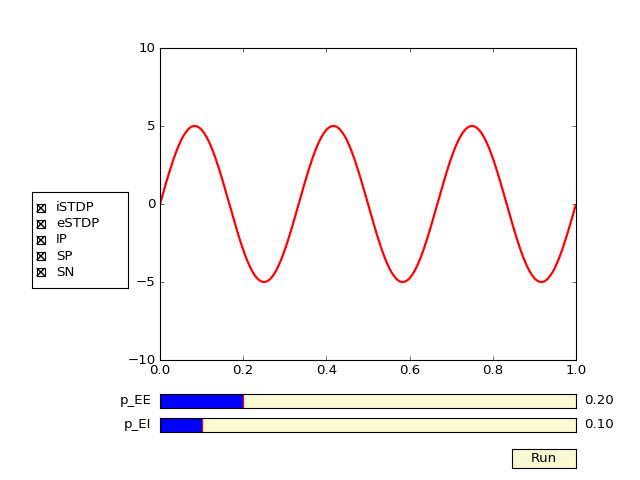

/Users/justinshenk/cv/lib/python3.5/site-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/justinshenk/cv/lib/python3.5/site-packages/ipykernel/__main__.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 0.775   0.1875  0.0375  0.0125  0.025   0.075   0.0375  0.0125  0.025   0.
  0.      0.2875  0.4     0.0625  0.075   0.075   0.1     0.0625  0.025   0.
  0.      0.4375  0.4125  0.0125  0.      0.05    0.175   0.05    0.0375
  0.0375  0.      0.      0.4375  0.325   0.      0.      0.3375  0.3875
  0.0625  0.0125  0.      0.025   0.2625  0.0375  0.0125  0.      0.025
  0.25    0.075   0.075   0.0375  0.0125  0.025   0.      0.      0.375
  0.25    0.025   0.0125  0.0375  0.1125  0.05    0.025   0.0125  0.
  0.0375  0.2625  0.0125  0.      0.1125  0.375   0.125   0.025   0.025
  0.025   0.      0.0125  0.4375  0.0375  0.      0.0125  0.175   0.1     0.05
  0.05    0.0125  0.      0.0125  0.4125  0.075   0.0125  0.025   0.075
  0.05    0.1125  0.025   0.0375  0.0125  0.0125  0.0875  0.0625  0.0375
  0.1125  0.125   0.175   0.2     0.0375  0.0375  0.      0.      0.5125
  0.5125  0.075   0.0125  0.0125  0.05    0.1     0.05    0.      0.
  0.3125  0.2     0.025   0.0125  0.025   0.075  

In [13]:
from matplotlib.widgets import Slider, Button, RadioButtons,CheckButtons
'''
Select parameters and plasticity mechanisms and nstantiate 
a new neural network

Prints activation rate over time

NOTE: Graph below is a placeholder for a future graph

'''
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
SN = 1
SP = 1
IP = 1
p_EE = 0.1
p_EI = 0.2
eSTDP = 1
iSTDP = 1
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])
pEE = 0.1
axcolor = 'lightgoldenrodyellow'
axpEE = plt.axes([0.25, 0.1, 0.65, 0.03], axisbg=axcolor)
axpEI = plt.axes([0.25, 0.15, 0.65, 0.03], axisbg=axcolor)

spEE = Slider(axpEE, 'p_EI', 0.0, 1.0, valinit=0.1)
spEI = Slider(axpEI, 'p_EE', 0., 1.0, valinit=0.2)

def update(val):
    global p_EE
    global p_EI
    print (spEE.val)
    p_EE = spEE.val
    p_EI = spEI.val
    fig.canvas.draw_idle()

spEE.on_changed(update)
spEI.on_changed(update)

runax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(runax, 'Run', color=axcolor, hovercolor='0.975')

def run():
    global S
    S = SORN(SN,SP,IP,iSTDP,eSTDP,p_EE,p_EI)
    S.run_network()
button.on_clicked(run())

rax = plt.axes([0.05, 0.4, 0.15, 0.2])
check = CheckButtons(rax, ('iSTDP', 'eSTDP', 'IP','SP','SN'), (True,True,True,True,True))

def set_plasticity(label):
    global iSTDP
    global eSTDP
    global TP
    global SP
    global SN
    global IN
    if label == 'iSTDP':
        iSTDP = 1
    elif label == 'eSTDP':
        eSTDP = 1
    elif label == 'IP':
        IP = 1
    elif label == 'SP':
        SP = 1
    elif label == 'SN':
        SN = 1

check.on_clicked(set_plasticity)

plt.show()